In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import matplotlib
from PIL import Image
import pickle

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Image size = 400,400


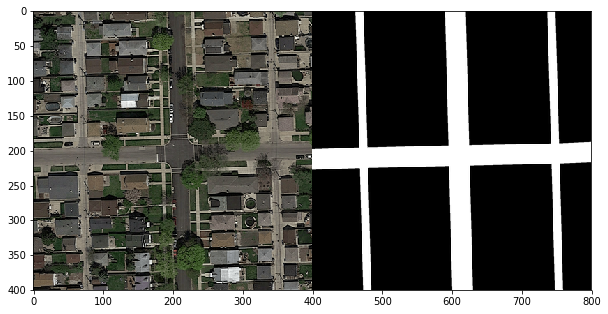

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [6]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [7]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0



In [8]:
X = np.asarray(img_patches)
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [9]:
print(X.shape)

(62500, 16, 16, 3)


In [10]:
from sklearn import cross_validation
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2)
x_test.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(12500, 16, 16, 3)

In [11]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

import keras
from keras.models import Sequential,load_model
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K

Using TensorFlow backend.


In [12]:


batch_size = 64
num_classes = 2
epochs = 20

# input image dimensions
img_rows, img_cols = patch_size, patch_size

# the data, shuffled and split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    #x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    #x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [13]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 16, 16, 3)
50000 train samples
12500 test samples


In [14]:

# construct the image generator for data augmentation
aug = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [15]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

"""model.add(ZeroPadding2D((1, 1), input_shape=input_shape))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))"""

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(batch_size))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
"""model.add(Flatten())
model.add(Dense(batch_size, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(batch_size, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))"""

"model.add(Flatten())\nmodel.add(Dense(batch_size, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(batch_size, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(1, activation='softmax'))"

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 128)       3584      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
activation_3 (Activation)    (None, 4, 4, 128)         0         
__________

In [19]:
loadModel = True
if not loadModel:
    """model.fit(X, Y,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_split=0.1)"""
    H = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test), steps_per_epoch=len(x_train)*2 // batch_size,
                        epochs=60, verbose=1)
else:
    model = load_model('hype1000.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.294209071121
Test accuracy: 0.874640000019


In [26]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 60
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Santa/Not Santa")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

NameError: name 'H' is not defined

In [33]:
model.save_weights('hype2.h5')
model.save('model1.h5')

In [21]:
def load_test_imgs():
    #1444 tiles per image
    n=50
    test_directory = "test_set_images/test_"
    imgs = [load_image(test_directory + str(i)+"/test_"+str(i)+".png") for i in range(1,n+1)]
    img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    return imgs, np.asarray(img_patches)

imgs_test, a = load_test_imgs()

In [22]:
yolo = model.predict(a, batch_size=batch_size)

In [23]:
print(yolo.shape)
print(yolo[0])
G = np.zeros((72200,1))
for i in range(len(G)):
    if yolo[i]<0.5:
        G[i] = 0
    else:
        G[i] = 1

(72200, 1)
[ 0.41063958]


In [24]:
def showTestImg(idx):

    w = 608
    h = 608
    size= 1444
    predicted_im = label_to_img(w, h, patch_size, patch_size, G[size*idx:size*(idx+1)])
    cimg = concatenate_images(imgs_test[idx], predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

    new_img = make_img_overlay(imgs_test[idx], predicted_im)

    plt.imshow(new_img)

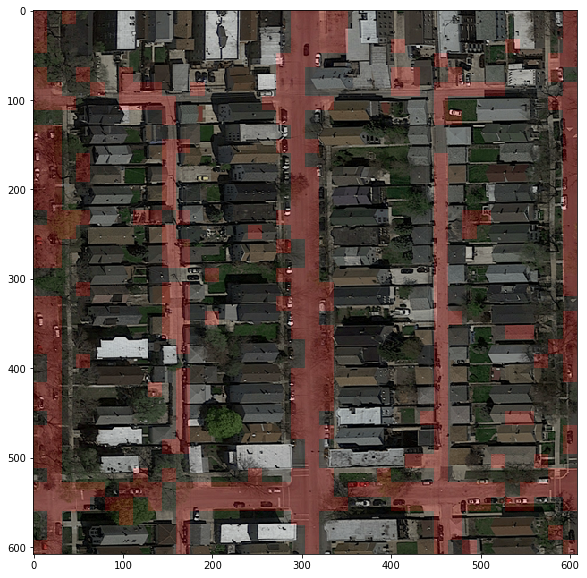

In [25]:
#la 5, 6 et 8 sont pas mal
idx_test = 5
showTestImg(idx_test)

In [27]:
def saveTestImgsOutput():
    w = 608
    h = 608
    size = 1444
    for i in range(50):
        predicted_im = label_to_img(w, h, patch_size, patch_size, G[size*i:size*(i+1)])
        nameToSave = 'test_set_results_with_imgGenerator2/img_'+str(i+1)+'.png'
        H = np.zeros((w,h,3))
        H[predicted_im>0.5] = [1,1,1]
        H[predicted_im<0.5] = [0,0,0]
        matplotlib.image.imsave(nameToSave, H)
saveTestImgsOutput()

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 128)       3584      
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
activation_6 (Activation)    (None, 12, 12, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
activation_7 (Activation)    (None, 4, 4, 128)         0         
__________